In [8]:
# -*- coding: utf-8 -*-

import jieba
import jieba.posseg as pseg
import numpy as np
import pandas as pd
import os,sys,re
import pickle as pickle
import argparse
from nltk.corpus import words
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nlp_utils import LemmaTokenizer, Bigram
from nlp_utils import read_docs_new, get_topic_words

print ('start ~~~')
TEXT_DATA_DIR = '/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/example'
MAX_NB_WORDS = 20000
NB_TOPICS = 14

# Read documents
print ('reading docs')
docs, doc_classes = read_docs_new(TEXT_DATA_DIR)
print ('reading docs done')

# jieba custom setting.
print ('dic setting')
jieba.set_dictionary('/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/dict.txt.big.txt')
print ('dic setting done')

# load stopwords
print ('stopwords setting')
stopwords = open('/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/stopWords.txt', encoding='utf-8').read().split('\n')
print ('stopwords setting done')

# segment
print ('jieba cutting')
token_docs = [list(jieba.cut(doc, cut_all=False)) for doc in docs]
print ('jieba cutting done')

print ('stopwords removing')
filtered_token_docs = []
for i in range(len(token_docs)):
    bag_i = []
    for w in token_docs[i]:
        pos_w = pseg.cut(w)
        for w, f in pos_w:
            if f == 'n' or  f == 'nr' or f == 'ns' or f == 'nt' or f == 'nz' or f == 't' or f == 's' or  f == 'v' or f == 'f':
                bag_i.append(w)
    with open("filtered_token_docs.txt", "a") as output:
        output.write(str(bag_i))
    print ('%i is done' %(i))
    filtered_token_docs.append(bag_i)
print ('stopwords removing done')

print ('phrasering')
phraser = Bigram()
bigram_docs = phraser(filtered_token_docs)
print ('vectorizering')
vectorizer = CountVectorizer(min_df=10, max_df=0.5,
                              max_features=MAX_NB_WORDS,
                              preprocessor = lambda x: x,
                              tokenizer = lambda x: x)
print ('to corpus')
corpus = vectorizer.fit_transform(bigram_docs)

Building prefix dict from /Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/dict.txt.big.txt ...
Loading model from cache /var/folders/8n/5f6_bdvj5l90w50bpdzhtq6c0000gn/T/jieba.u9fbfaacb2591698067ea6c8ae7525ffb.cache


start ~~~
reading docs
reading docs done
dic setting
dic setting done
stopwords setting
stopwords setting done
jieba cutting


Loading model cost 1.997 seconds.
Prefix dict has been built succesfully.


jieba cutting done
stopwords removing
0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
stopwords removing done
phrasering
vectorizering
to corpus


In [125]:
print (len(token_docs))

35


In [97]:
# Build model and fit
lda_model = LatentDirichletAllocation(
    n_components=NB_TOPICS,
    learning_method='online',
    max_iter=10,
    batch_size=2000,
    verbose=1,
    max_doc_update_iter=100,
    n_jobs=-1,
    random_state=0)
lda = lda_model.fit(corpus)
doc_topics_mtx = lda.transform(corpus)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [98]:
# get words per topic
topic_words = get_topic_words(lda,vectorizer.get_feature_names(),10)

# save the results
df = pd.DataFrame({'news_class': doc_classes})
df.to_csv('/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/data_processed/news_class.txt', index=False)
pickle.dump(lda, open('/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/data_processed/news_lda_model.p', "wb"))
pickle.dump(topic_words, open('/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/data_processed/news_topic_words_final_model.p', "wb"))
pickle.dump(doc_topics_mtx, open('/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/data_processed/news_document_topics_mtx.p', "wb"))
# so we can read it with R
np.save('/Users/yupingkuo/Desktop/Topic_Modelling_and_Self_Organizing_Maps-master/data_processed/news_document_topics_mtx.npy', doc_topics_mtx)

In [99]:
# LDA plot
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, corpus, vectorizer)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.111478  0.019450       1        1  30.060419
10     0.105690  0.058680       2        1  23.456844
6      0.043136 -0.119845       3        1  14.937801
12    -0.064476  0.041062       4        1   9.404729
11    -0.065467  0.008929       5        1   7.528836
1     -0.018362  0.015714       6        1   3.801131
7     -0.012772  0.004757       7        1   3.736504
4     -0.008796 -0.008632       8        1   3.064239
0     -0.018400 -0.003001       9        1   1.591759
8     -0.015080  0.002146      10        1   1.400564
5     -0.015076 -0.006275      11        1   0.551901
13    -0.012108 -0.001694      12        1   0.386576
9     -0.013403 -0.006018      13        1   0.039349
2     -0.016363 -0.005273      14        1   0.039349, topic_info=     Category       Freq Term      Total  loglift  logprob
1090  Default  12.000000   搭配  12.000000  30.0000  30.0000
2214  Default   9.000000  高露洁   9.000000  29.0000  29.0000
1455  Default  13.000000   瑞典  13.000000  28.0000  28.0000
1865  Default  28.000000    让  28.000000  27.0000  27.0000
2108  Default  55.000000  阿根廷  55.000000  26.0000  26.0000
1408  Default   8.000000   牙齿   8.000000  25.0000  25.0000
181   Default  35.000000   伊瓜  35.000000  24.0000  24.0000
1182  Default  98.000000    是  98.000000  23.0000  23.0000
1319  Default  21.000000   没有  21.000000  22.0000  22.0000
1343  Default   6.000000  消费者   6.000000  21.0000  21.0000
1261  Default  38.000000   梅西  38.000000  20.0000  20.0000
1010  Default   6.000000   抗敏   6.000000  19.0000  19.0000
58    Default  45.000000  世界杯  45.000000  18.0000  18.0000
1439  Default  32.000000   球员  32.000000  17.0000  17.0000
57    Default  10.000000   世界  10.000000  16.0000  16.0000
327   Default   9.000000    出   9.000000  15.0000  15.0000
187   Default  14.000000    会  14.000000  14.0000  14.0000
485   Default   5.000000   口腔   5.000000  13.0000  13.0000
1438  Default  14.000000    球  14.000000  12.0000  12.0000
867   Default  10.000000   张路  10.000000  11.0000  11.0000
2086  Default  13.000000   问题  13.000000  10.0000  10.0000
1457  Default   8.000000  瑞典队   8.000000   9.0000   9.0000
2069  Default   6.000000    错   6.000000   8.0000   8.0000
1088  Default   8.000000    搭   8.000000   7.0000   7.0000
949   Default   7.000000   感觉   7.000000   6.0000   6.0000
50    Default   5.000000   专效   5.000000   5.0000   5.0000
1407  Default   5.000000   牙膏   5.000000   4.0000   4.0000
553   Default   8.000000  商瑞华   8.000000   3.0000   3.0000
1168  Default   9.000000   时尚   9.000000   2.0000   2.0000
373   Default   8.000000    前   8.000000   1.0000   1.0000
...       ...        ...  ...        ...      ...      ...
1560  Topic14   0.001336   神采   1.641230   0.7272  -7.5176
1496  Topic14   0.001346   目光   1.672137   0.7159  -7.5102
1934  Topic14   0.001429   足以   1.925593   0.6347  -7.4503
1531  Topic14   0.001426   眼里   1.928244   0.6307  -7.4528
1626  Topic14   0.001296  精氨酸   1.624337   0.7068  -7.5482
55    Topic14   0.001380   世人   1.853564   0.6377  -7.4854
1629  Topic14   0.001258   素色   1.545224   0.7273  -7.5777
1578  Topic14   0.001352   租用   1.820573   0.6353  -7.5057
1511  Topic14   0.001368   相貌   1.878440   0.6155  -7.4943
13    Topic14   0.001332   上旬   1.794451   0.6344  -7.5211
733   Topic14   0.001351  实力派   1.896479   0.5935  -7.5067
1503  Topic14   0.001326   直觉   1.826963   0.6122  -7.5253
772   Topic14   0.001337  小男孩   1.929593   0.5657  -7.5171
1640  Topic14   0.001305   纸条   1.788112   0.6180  -7.5410
1450  Topic14   0.001321   球鞋   1.912777   0.5627  -7.5289
1746  Topic14   0.001331   节奏   1.985731   0.5323  -7.5219
1049  Topic14   0.001322   挡出   1.934834   0.5521  -7.5281
1362  Topic14   0.001322   满足   1.986553   0.5256  -7.5282
1524  Topic14   0.001410   眼妆   3.008528   0.1751  -7.4636
355   Topic14   0.001313   刚跑   1.941046   0.5417  -7.5353
1918  Topic14   0.001487 

In [102]:
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import numpy as np
import pickle as pickle
import sompy

# topic matrix, created with lemmatization, bigrams and 10 topics
topic_matrix = pickle.load(open("data_processed/news_document_topics_mtx.p", "rb"))

mapsize = [30,30]
som = sompy.SOMFactory.build(
    topic_matrix,
    mapsize,
    mask=None,
    mapshape='planar',
    lattice='rect',
    normalization='var',
    initialization='pca',
    neighborhood='gaussian',
    training='batch',
    name='sompy')
som.train(n_job=8, verbose='info')

 Training...
 pca_linear_initialization took: 0.003000 seconds
 Rough training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 8

 epoch: 1 ---> elapsed time:  0.118000, quantization error: 3.021334

 epoch: 2 ---> elapsed time:  0.107000, quantization error: 3.024490

 epoch: 3 ---> elapsed time:  0.110000, quantization error: 3.008440

 epoch: 4 ---> elapsed time:  0.110000, quantization error: 3.008440

 epoch: 5 ---> elapsed time:  0.111000, quantization error: 3.008440

 epoch: 6 ---> elapsed time:  0.111000, quantization error: 3.008440

 epoch: 7 ---> elapsed time:  0.107000, quantization error: 3.008440

 epoch: 8 ---> elapsed time:  0.111000, quantization error: 3.008440

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 11

 epoch: 1 ---> elapsed time:  0.106000, quantization error: 3.008440

 epoch: 2 ---> elapsed time:  0.106000, quantization error: 3.008440

 epoch: 3 ---> elapsed time:  0.112000, quantization error: 3.008440

 ep

In [64]:
# The method find_k_nodes will find the nearest neightbors given an input. 
# The nearest neightbor will then be the location of that observation in 
# the map.
node_hits = []
for i in range(len(topic_matrix)):
    data = topic_matrix[i].reshape(1,-1)
    loc = som.find_k_nodes(data)[1][0][0]
    node_hits.append(loc)

from collections import Counter
node_counts = Counter(node_hits)

print(node_counts)

Counter({1: 9, 7: 6, 6: 5, 0: 5, 5: 4, 3: 2, 2: 2, 8: 1, 4: 1})


In [103]:
len(node_counts)

9

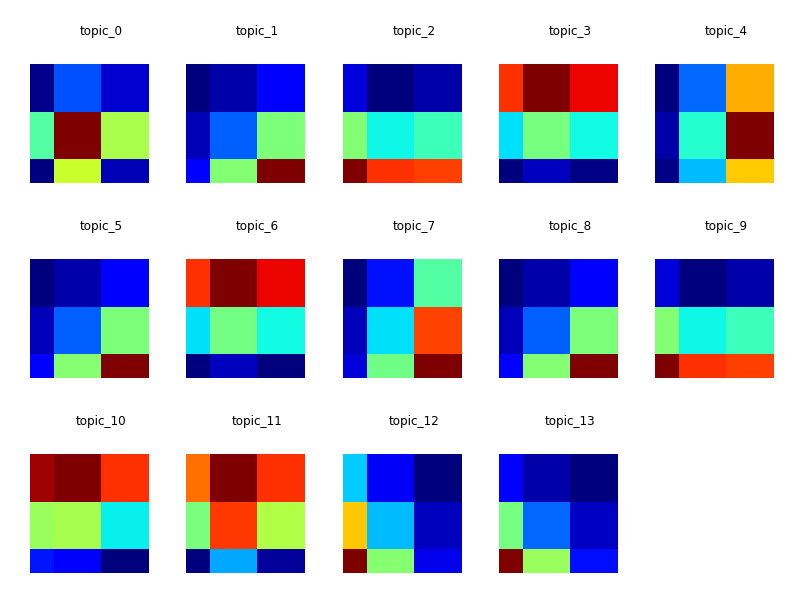

In [104]:
som.component_names = ["_".join([t,str(i)]) for i,t in enumerate(['topic']*14)]
v = sompy.mapview.View2DPacked(30, 30, ' ',text_size=10)
v.show(som, what='codebook', which_dim='all', cmap='jet', col_sz=5)

In [105]:
import pickle as pickle
topic_words = pickle.load(open("data_processed/news_topic_words_final_model.p", "rb"))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


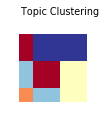

In [118]:
v = sompy.mapview.View2DPacked(10, 10, 'Topic Clustering',text_size=10)
#cl = som.cluster(n_clusters=10, random_state=0)
cl = som.cluster(n_clusters=5)
# I am using the default plotting methods. I am sure this can be made prettier...
v.show(som, what='cluster')

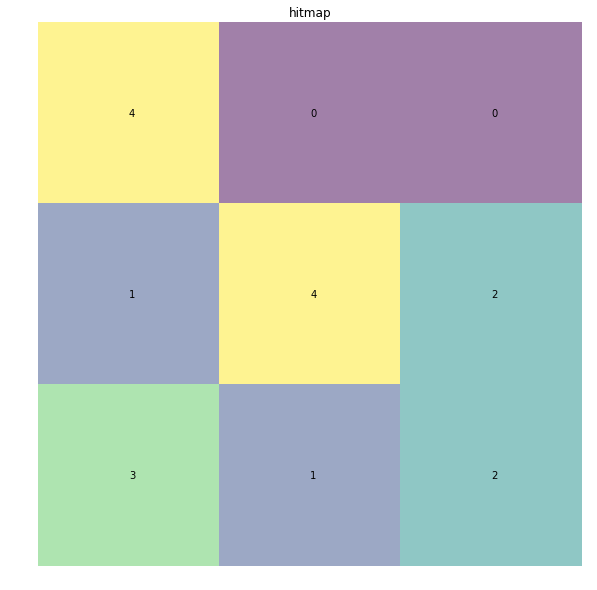

array([[0, 0, 0],
       [0, 1, 1],
       [0, 2, 2],
       [1, 0, 3],
       [1, 1, 4],
       [1, 2, 5],
       [2, 0, 6],
       [2, 1, 7],
       [2, 2, 8]])

In [119]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)